## Задание: 

1. Проанализировать тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли $p-value$  меньше по сравнению с обычным CTR?
2. Проанализировать тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли $p-value$ меньше по сравнению с обычным CTR?

Данные следует брать в том же диапазоне, в котором проводился АБ-тест (с 2024-03-29 по 2024-04-04 включительно).
При выполнении задания нужно обосновать и аргументировать выводы.

In [7]:
import pandahouse 
import pandas as pd
import random 
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [8]:
connection = { #здесь были параметры подключения
    'host': "...",
    'password': "...",
    'user': '...',
    'database': "..."
}

In [9]:
q1 = """
    select exp_group,
           user_id, 
           sum(action='view') as views, 
           sum(action='like') as likes, 
           sum(action='like')/sum(action='view') as ctr
    from {db}.feed_actions
    where date(time) between date('2024-03-29') and date('2024-04-04')
        and exp_group in (0, 3)
    group by user_id, exp_group
"""

q2 = """
    select exp_group,
           user_id, 
           sum(action='view') as views, 
           sum(action='like') as likes, 
           sum(action='like')/sum(action='view') as ctr
    from {db}.feed_actions
    where date(time) between date('2024-03-29') and date('2024-04-04')
        and exp_group in (1, 2)
    group by user_id, exp_group
"""

first = pandahouse.read_clickhouse(q1, connection=connection)
second = pandahouse.read_clickhouse(q2, connection=connection)

In [10]:
first.groupby('exp_group').count()

,user_id,views,likes,ctr
exp_group,,,,
0,9920,9920,9920,9920
3,10002,10002,10002,10002


In [11]:
second.groupby('exp_group').count()

,user_id,views,likes,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


### Мини-блок теории

Линеаризация метрики:
- Посчитать общий CTR в контрольной группе $CTR_{control} = \frac{sum(likes)}{sum(views)}$ 
- Посчитать в обеих группах поюзерную метрику $linearized\_likes = likes - CTR_{control} * views$
- Сравнить t-тестом отличия в группах по метрике $linearized\_likes$

Если метрика прокрасилась $\Rightarrow$ исходная метрика вида $\frac{x}{y}$ тоже должна прокраситься.

### Сравнение для 0 и 3 группы 

Посмотрим на распределение CTR в группах:

In [15]:
sns.set(rc={'figure.figsize':(20, 10)})

<Axes: xlabel='ctr', ylabel='Count'>

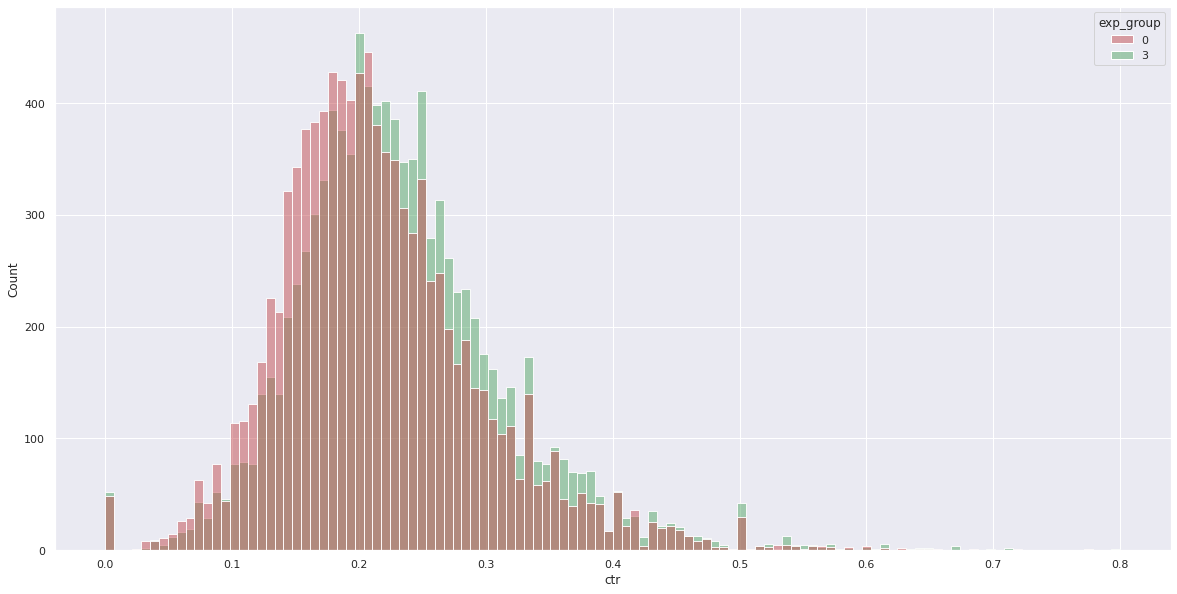

In [16]:
sns.histplot(data=first, x='ctr', hue='exp_group', palette=['r', 'g'], alpha=0.5, kde=False)

In [17]:
ctr_control = first[first.exp_group==0].likes.sum()/first[first.exp_group==0].views.sum()
first['linear_likes'] = first.likes - ctr_control * first.views

Распределение CTR в группах после линеаризации:

<Axes: xlabel='linear_likes', ylabel='Count'>

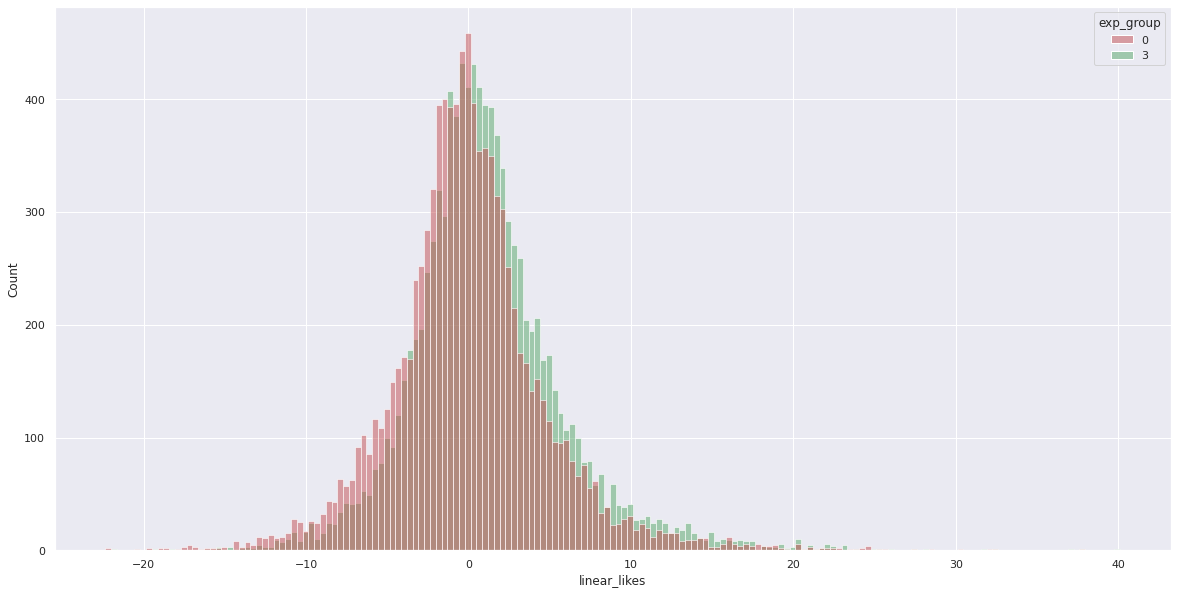

In [19]:
sns.histplot(data=first, x='linear_likes', hue='exp_group', palette=['r', 'g'], alpha=0.5, kde=False)

In [30]:
ttest_p_value_1 = stats.ttest_ind(first[first.exp_group==0].ctr, first[first.exp_group==3].ctr, equal_var=False)[1]
linear_ttest_p_value_1 = stats.ttest_ind(first[first.exp_group==0].linear_likes, first[first.exp_group==3].linear_likes, equal_var=False)[1]

In [31]:
print(ttest_p_value_1)
print(linear_ttest_p_value_1)

6.216047483062228e-44
1.4918137745326139e-58


### Вывод

Отличие после линеаризации, конечно же, есть (графики распределения сместились к началу координат), но оно незаметное, поскольку распределения остались в таком же положении относительно друг друга - накладываются друг на друга. Значение p-value после линеаризации уменьшилось на несколько порядков относительно p-value классического CTR, но в целом, это не влияет на характер утверждения относительно нулевой гипотезы.

### Сравнение для 1 и 2 группы 

Для начала посмотрим на распределение CTR в группах:

<Axes: xlabel='ctr', ylabel='Count'>

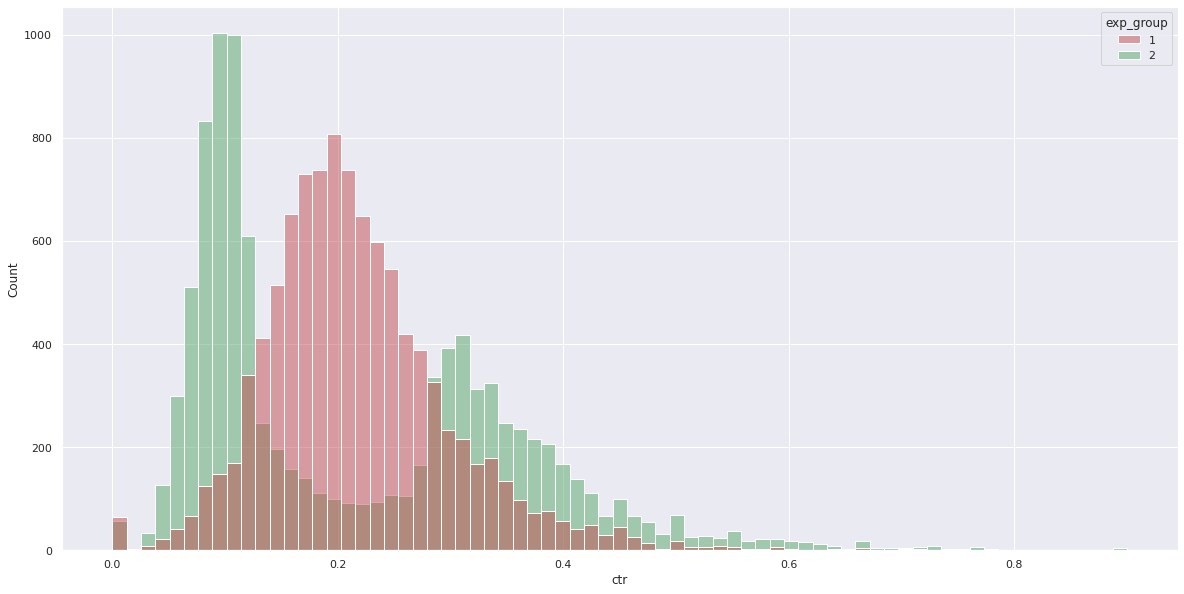

In [32]:
sns.set(rc={'figure.figsize':(20, 10)})
sns.histplot(data=second, x='ctr', hue='exp_group', palette=['r', 'g'], alpha=0.5, kde=False)

In [33]:
ctr_control = second[second.exp_group==1].likes.sum()/second[second.exp_group==1].views.sum()
second['linear_likes'] = second.likes - ctr_control * second.views

Распределение CTR в группах после линеаризации:

<Axes: xlabel='linear_likes', ylabel='Count'>

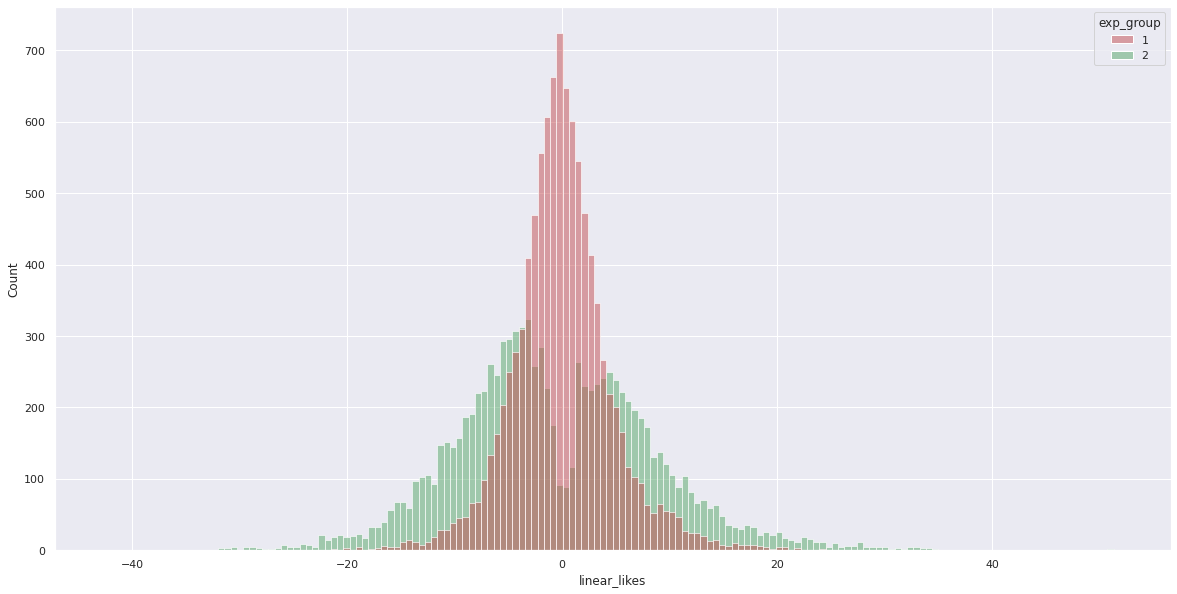

In [34]:
sns.histplot(data=second, x='linear_likes', hue='exp_group', palette=['r', 'g'], alpha=0.5, kde=False)

In [35]:
ttest_p_value_2 = stats.ttest_ind(second[second.exp_group==1].ctr, second[second.exp_group==2].ctr, equal_var=False)[1]
linear_ttest_p_value_2 = stats.ttest_ind(second[second.exp_group==1].linear_likes, second[second.exp_group==2].linear_likes, equal_var=False)[1]

In [36]:
print(ttest_p_value_2)
print(linear_ttest_p_value_2)

0.685373331140751
2.9805064038668164e-09


### Вывод

Отличие после линеаризации есть, графики распределения сместились к началу координат, но, что более важно, поменялась форма распределения тестовой группы, "пики" стали почти одинаковыми по высоте, причём они оба ниже "пика" распределения контрольной группы. Значение p-value после линеаризации стало меньше 0.05, в то время как до линеаризации оно было больше 0.05, то есть характер утверждения относительно нулевой гипотезы изменился на противоположный. До линеаризации мы принимали нулевую гипотезу, а сейчас вынуждены её отвергнуть.
